### Inspired by: https://www.youtube.com/watch?v=aU8OF0htbTo&t=133s&ab_channel=PatrickLoeber

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path

In [2]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda:0")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    device = torch.device("cpu")
print(f"Using device: {device}")

data_dir = Path(r"/mnt/c/Users/saulg/Desktop/dl_datasets/dogs_vs_cats")

GPU is available!
Using device: cuda:0


In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(data_dir / "train", transform=train_transform)
valid_dataset = torchvision.datasets.ImageFolder(data_dir / "valid", transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(data_dir / "test", transform=test_transform)

In [5]:
for image,label in train_dataset:
    print(image.shape)
    break

torch.Size([3, 224, 224])


In [6]:
# check class names
print(train_dataset.classes)

['cat', 'dog']


In [7]:
batch_size_train = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_train, shuffle=False)

In [8]:
iter_ = iter(train_loader)
image,label = next(iter_)
print(image.shape)
print(label)

torch.Size([64, 3, 224, 224])
tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

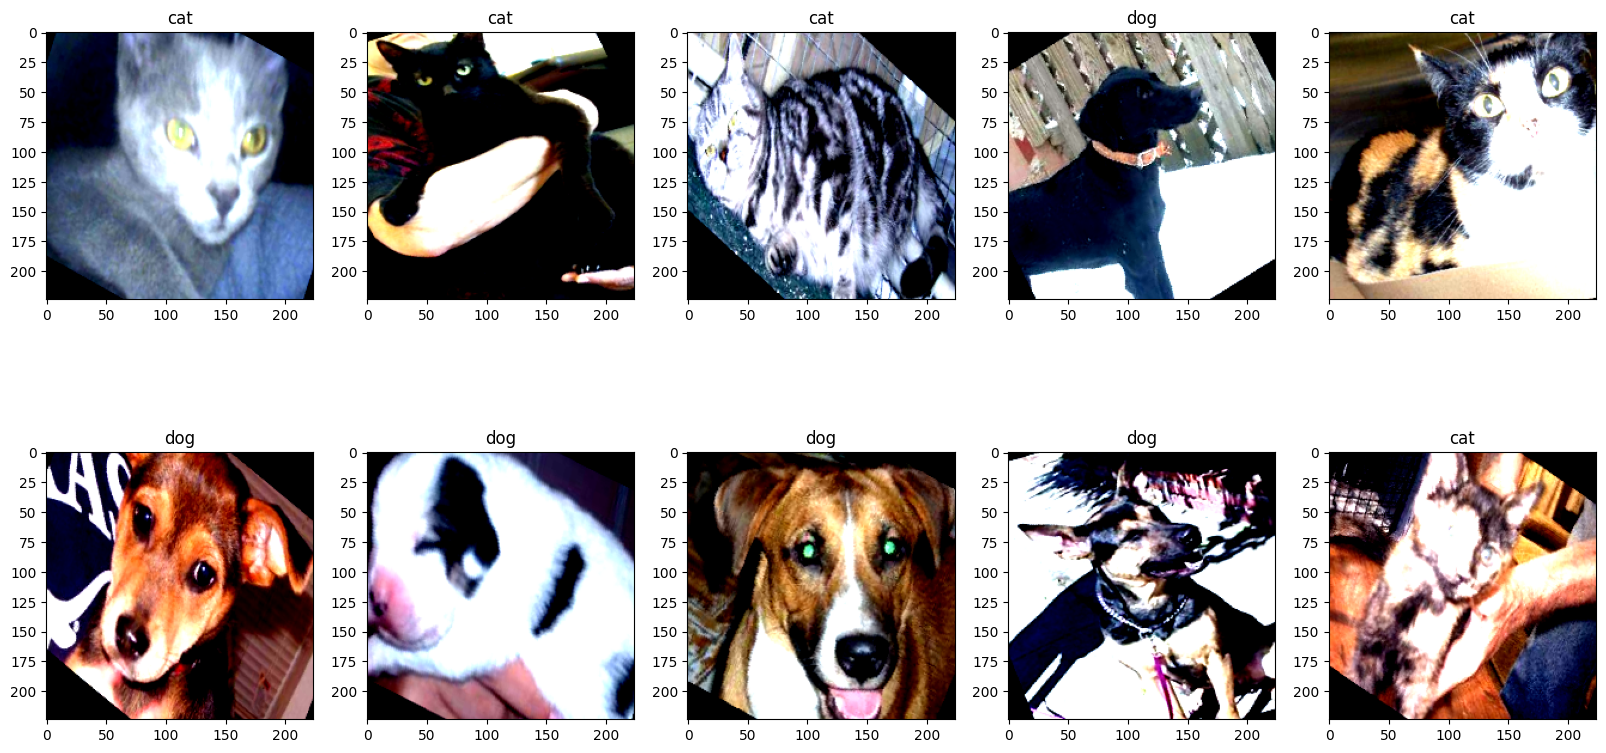

In [10]:
def image_convert(
    img, 
    std=[0.5,0.5,0.5], 
    mean=[0.5,0.5,0.5]
    ):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    img = img*std + mean
    return img


def plot_sample_images(dataloader=train_loader, n_images=batch_size_train):
        iter_ = iter(train_loader)
        images,labels = next(iter_)
        an_ = {'0':'cat','1':'dog'}
        
        plt.figure(figsize=(20,10))
        for idx in range(n_images):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()

plot_sample_images(n_images=10)

### Building the Network

In [12]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from torch import nn
class classification_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512,120)
        self.linear2=nn.Linear(120,2)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
model_ = classification_head().to(device)
model.fc = model_

In [16]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# freeze all layers
for param in model.parameters():
        param.requires_grad = False
# unfreeze the last layer
for param in model.fc.parameters():
        param.requires_grad = True

In [ ]:
# output = model(example_data)

# # convert output probabilities to predicted class
# probabilities = F.softmax(output, dim=1)
# print(probabilities)
# _, preds_tensor = torch.max(probabilities, 1)
# print(preds_tensor)

### Define training loop

In [22]:
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(train_loader)

    return loss_total, accuracy

# Validation function
def validate(model, data_loader, loss_fn, device):
    model.eval()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss_total += loss.item()
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(data_loader)

    return loss_total, accuracy

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    return torch.cat(predictions), accuracy


def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            y_hat = model(x)
            _, predicted = y_hat.max(1)
            predictions.append(predicted)

    return torch.cat(predictions)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model_weights = None

    def early_stop(self, validation_loss, model):
        print(f"Early Stopping counter: {self.counter} out of {self.patience}")
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 1
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [24]:
# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training parameters
n_epochs = 15
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, loss function, and optimizer
model = model.to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    # Training
    train_loss, train_acc = train(model, train_loader, optimizer, criteria, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"[{epoch+1}/{n_epochs}] Train loss: {train_loss:.4f} acc: {train_acc:.2f}%")

    # Validation
    val_loss, val_acc = validate(model, test_loader, criteria, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'[{epoch+1}/{n_epochs}] Val loss: {val_loss:.4f} acc: {val_acc:.2f}%')

    if early_stopper.early_stop(val_loss, model):
        early_stopper.save_best_weights(model)
        print("Patience Depleated: Early Stopping triggered.")
        break
early_stopper.restore_best_weights(model)

Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

[1/15] Train loss: 0.0468 acc: 98.30%


Training Progress:   7%|▋         | 1/15 [00:11<02:44, 11.73s/it]

[1/15] Val loss: 0.0117 acc: 99.00%
Early Stopping counter: 0 out of 5
[2/15] Train loss: 0.0450 acc: 98.30%


Training Progress:  13%|█▎        | 2/15 [00:23<02:32, 11.77s/it]

[2/15] Val loss: 0.0117 acc: 99.00%
Early Stopping counter: 0 out of 5
[3/15] Train loss: 0.0436 acc: 98.30%


Training Progress:  20%|██        | 3/15 [00:35<02:21, 11.78s/it]

[3/15] Val loss: 0.0161 acc: 99.00%
Early Stopping counter: 1 out of 5
[4/15] Train loss: 0.0595 acc: 97.70%


Training Progress:  27%|██▋       | 4/15 [00:47<02:10, 11.83s/it]

[4/15] Val loss: 0.0109 acc: 100.00%
Early Stopping counter: 2 out of 5
[5/15] Train loss: 0.0374 acc: 98.60%


Training Progress:  33%|███▎      | 5/15 [00:59<01:58, 11.82s/it]

[5/15] Val loss: 0.0095 acc: 100.00%
Early Stopping counter: 3 out of 5
[6/15] Train loss: 0.0447 acc: 97.90%


Training Progress:  40%|████      | 6/15 [01:10<01:46, 11.86s/it]

[6/15] Val loss: 0.0097 acc: 100.00%
Early Stopping counter: 0 out of 5
[7/15] Train loss: 0.0436 acc: 98.60%


Training Progress:  47%|████▋     | 7/15 [01:23<01:36, 12.01s/it]

[7/15] Val loss: 0.0104 acc: 100.00%
Early Stopping counter: 1 out of 5
[8/15] Train loss: 0.0431 acc: 98.50%


Training Progress:  53%|█████▎    | 8/15 [01:35<01:25, 12.15s/it]

[8/15] Val loss: 0.0093 acc: 100.00%
Early Stopping counter: 2 out of 5
[9/15] Train loss: 0.0391 acc: 98.50%


Training Progress:  60%|██████    | 9/15 [01:48<01:13, 12.23s/it]

[9/15] Val loss: 0.0104 acc: 100.00%
Early Stopping counter: 3 out of 5
[10/15] Train loss: 0.0466 acc: 98.60%


Training Progress:  60%|██████    | 9/15 [02:00<01:20, 13.38s/it]

[10/15] Val loss: 0.0115 acc: 100.00%
Early Stopping counter: 4 out of 5
Early stopping


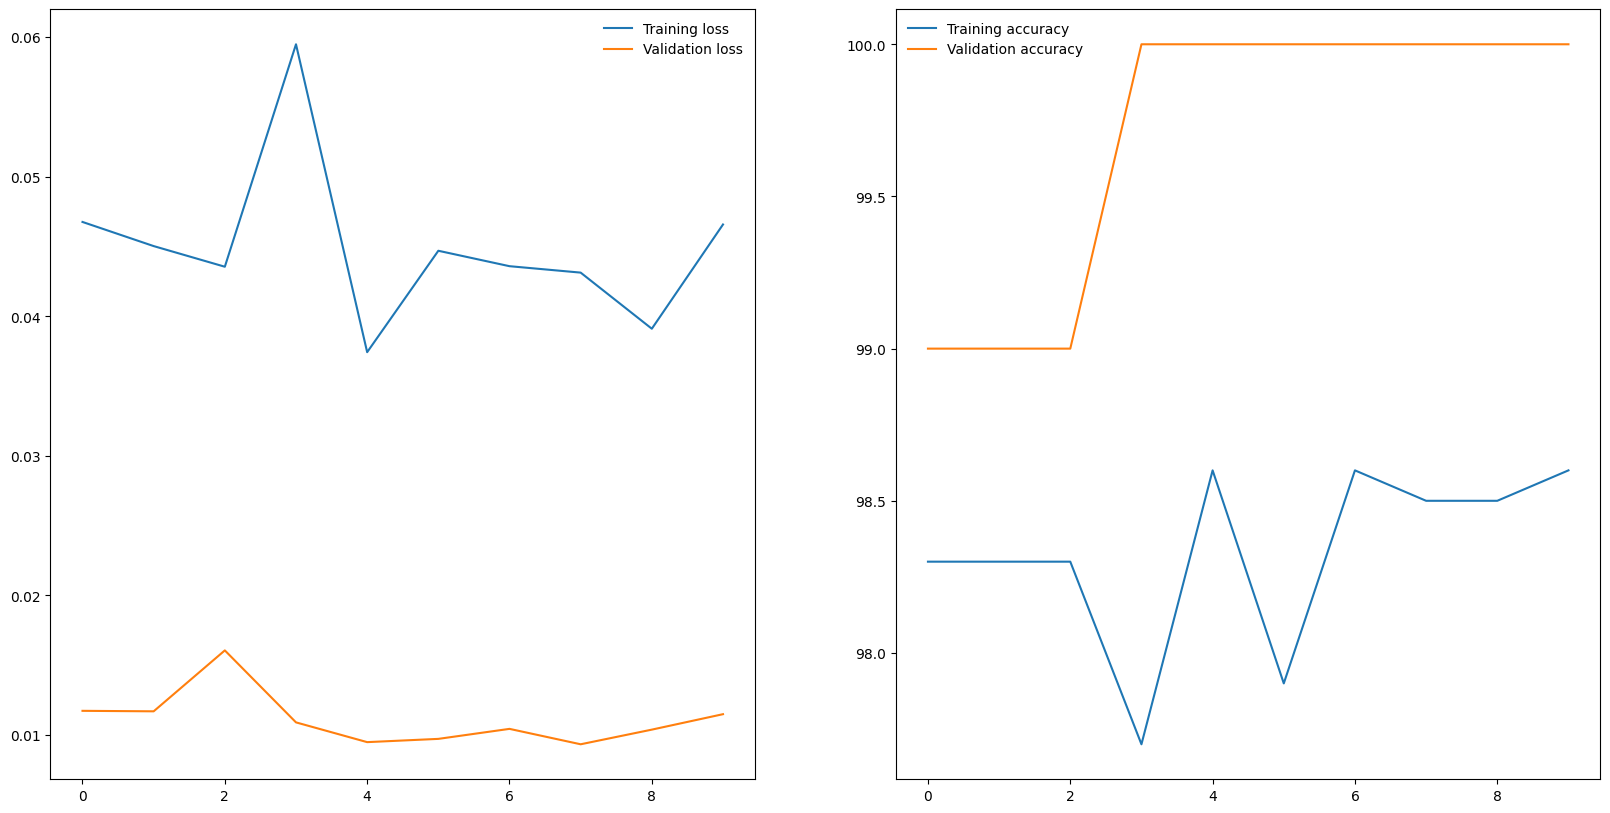

In [27]:
# plot loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

In [25]:
import numpy as np
def plot_val_images():

    label_dict = ['cat','dog']
 
    iter_ = iter(test_loader)
    images,labels = next(iter_)
    images = images.to(device)
    pred_labels = labels.to(device)

    
    img_out = model.forward(images)
    value, index_val = torch.max(img_out, 1)

    # label = label_dict[str(label)]
    fig = plt.figure(figsize=(35,9))
    for idx in np.arange(10):
        ax = fig.add_subplot(2,5,idx+1)
        plt.imshow(image_convert(images[idx]))
        label = labels[idx]  
        pred_label = pred_labels[idx]
        ax.set_title('Act {},pred {}'.format(label_dict[label],label_dict[pred_label]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

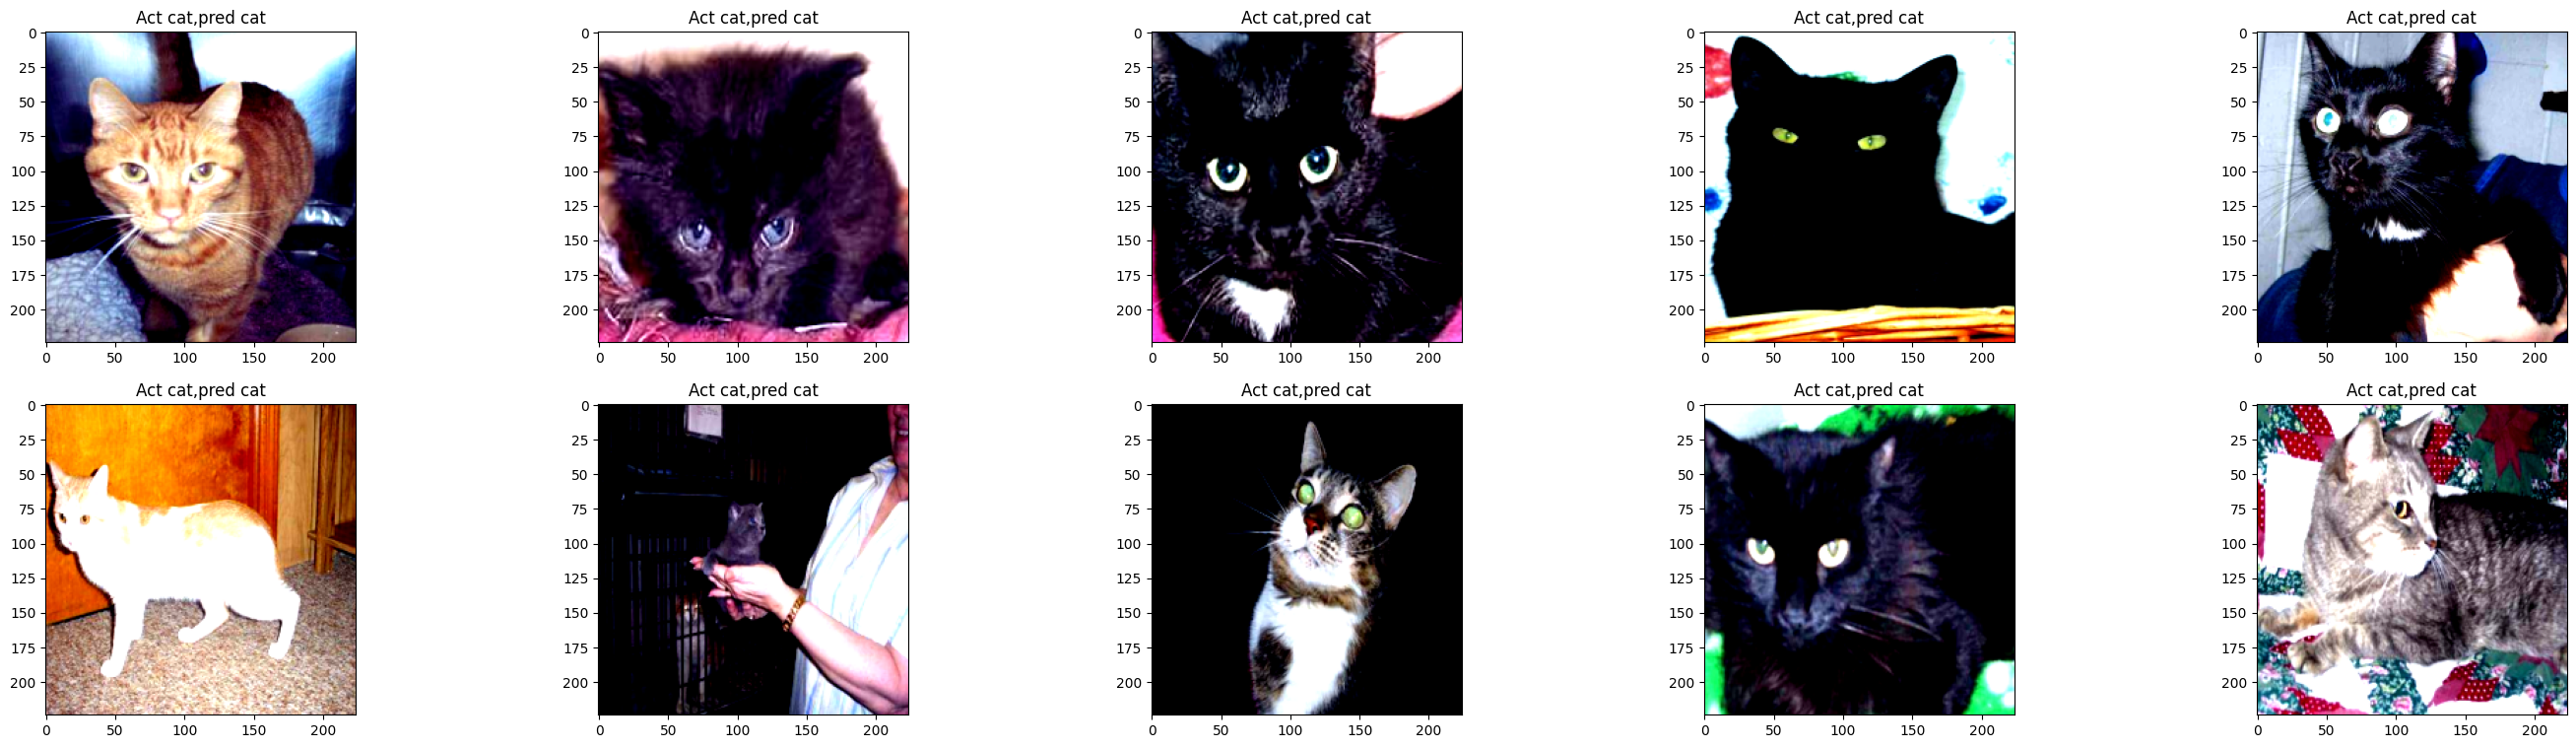

In [26]:
plot_val_images()